<a href="https://colab.research.google.com/github/JJay1010/K-software_-/blob/main/EunjuKang/project_02/Drug_Discrimination_230112_commit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project02. 경구약물분류

##1. 데이터 탐색

데이터 용량때문에 validation, 경구약제조합 데이터(3GB)만 다운받기로 결정

조합데이터의 경우 이미지에 여러 약제가 있으므로 이미지 분할 필요 -> bbox 좌표 이용


In [ ]:
# 파일 압축 풀기

# 원천 데이터: .png

# %cd /content/drive/MyDrive/Drugs/Data/img_data/img_data_drug
# !unzip -qq "/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/drugs_img.zip"

# 라벨링 데이터: .json
# %cd /content/drive/MyDrive/Drugs/Data/label_data/label_data_drug
# !unzip -qq "/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/drugs_label.zip"


### 데이터 확인해보기

In [ ]:
import PIL as pil
from PIL import Image
import glob 
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import json
import numpy as np

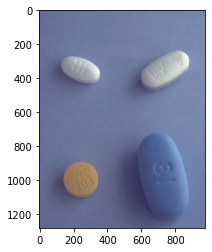

In [ ]:
# 경로로 이미지 불러오기, pillow 라이브러리
test_img = Image.open('/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-016235-027733-029667-031885/K-016235-027733-029667-031885_0_2_0_2_70_000_200.png')

plt.imshow(test_img)
plt.show()

In [ ]:
# 이미지에 해당하는 json 파일 불러오기
# 우선은 직접 찾아서 시도해봄

#/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016235-027733-029667-031885_json/K-016235/K-016235-027733-029667-031885_0_2_0_2_70_000_200.json


file_path = "/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016235-027733-029667-031885_json/K-016235/K-016235-027733-029667-031885_0_2_0_2_70_000_200.json"

with open(file_path, 'r') as file:
    data = json.load(file)
    #print(type(data))
    print(data['annotations'][0]['bbox'])
   
    #print(type(data['annotations'][0]))
    #print(data['annotations']{'bbox'}) #annotations[].bbox


[116, 264, 252, 179]


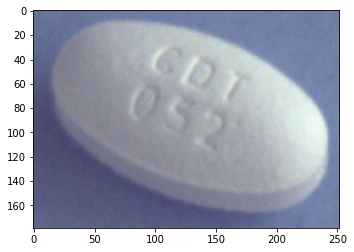

In [ ]:
# [116, 264, 252, 179] 좌표의 의미: 라이브러리마다 다름

x= 116
y= 264
w= 252
h= 179

# 이미지 크롭

cropped_img = test_img.crop((x, y, x+w, y+h))
plt.imshow(cropped_img)
plt.show()

이미지를 크롭하기 위해선 해당 json 파일을 알맞게 불러와야함

-> 이미지 파일 이름만으로 해당하는 json 파일을 불러오도록 코드 작성

-> 각 데이터가 어떻게 디렉토리에 저장되어있는지 분석

<원천데이터>

/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug
/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-016235-027733-029667-031885: 사진 폴더 경로 

K-016235-027733-029667-031885: 사진 폴더 이름 (4개)
- K-016235-027733-029667-031885_0_2_0_2_70_000_200.png
- K-016235-027733-029667-031885_0_2_0_2_75_000_200.png
- K-016235-027733-029667-031885_0_2_0_2_90_000_200.png
- K-016235-027733-029667-031885_index.png

<라벨링데이터>

/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016235-027733-029667-031885_json: json 폴더 경로


K-016235-027733-029667-031885_json: 라벨링 폴더 이름
- K-016235
	- K-016235-027733-029667-031885_0_2_0_2_70_000_200: json 파일 이름
	- K-016235-027733-029667-031885_0_2_0_2_75_000_200
	- K-016235-027733-029667-031885_0_2_0_2_90_000_200
- K-027733
- K-029667
- K-031885

### 이미지 파일과 json 파일 매칭 확인

데이터 처리 시에 바로 한 건 아니고 데이터를 분류하면서 오류가 발생하길래 해봄

In [ ]:
# glob으로 파일명 불러오기

In [ ]:
# 이미지 폴더 개수 확인

import os

file_list = os.listdir('/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug')
print(file_list[:10])
print(len(file_list))

['K-019232-020238-028424', 'K-018357-033026-038162', 'K-018357-033026-036637', 'K-018357-028424-038162', 'K-018357-033026-035206', 'K-019232-020238-020852', 'K-018357-028424-036637', 'K-018357-028424-035206', 'K-019232-020238-033026', 'K-019232-020238-024752']
501


In [ ]:
# json 폴더 개수 확인

json_file_list = os.listdir('/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug')
print(json_file_list[:10])
print(len(json_file_list))

['K-016548-021026-023203-044199_json', 'K-016548-021026-023203-033208_json', 'K-016548-021026-029871-044199_json', 'K-016548-021026-024850-029871_json', 'K-016548-021026-033208-033878_json', 'K-016548-021026-029871-033208_json', 'K-016548-021026-027993-044199_json', 'K-016548-021026-027993-033208_json', 'K-016548-021026-024850-027993_json', 'K-016548-021026-024850-033878_json']
501


In [ ]:
import glob

#/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016235-027733-029667-031885_json/K-016235
#/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016235-027733-029667-031885_json/K-016235/K-016235-027733-029667-031885_0_2_0_2_70_000_200.json

json_dir_path = '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug'
json_path_list = glob.glob(json_dir_path+'/*')

In [ ]:
print(json_path_list[:10])
print(len(json_path_list))

['/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-023203-044199_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-023203-033208_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-029871-044199_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-024850-029871_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-033208-033878_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-029871-033208_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-027993-044199_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-027993-033208_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-024850-027993_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-024850-033878_json']
501


In [ ]:
json_path_list_1 = glob.glob(json_dir_path+'/K-*_json')

In [ ]:
print(json_path_list_1[:10])
print(len(json_path_list_1))

['/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-023203-044199_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-023203-033208_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-029871-044199_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-024850-029871_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-033208-033878_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-029871-033208_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-027993-044199_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-027993-033208_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-024850-027993_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-024850-033878_json']
500


In [ ]:
# _json 파일 누락 확인하기 
json_check = []
for json_path in json_path_list_1:
  json_code = json_path.split('/')
  json_code = json_code[-1]
  json_check.append(json_code)

print(json_check[:10])
print(len(json_check))  

['K-016548-021026-023203-044199_json', 'K-016548-021026-023203-033208_json', 'K-016548-021026-029871-044199_json', 'K-016548-021026-024850-029871_json', 'K-016548-021026-033208-033878_json', 'K-016548-021026-029871-033208_json', 'K-016548-021026-027993-044199_json', 'K-016548-021026-027993-033208_json', 'K-016548-021026-024850-027993_json', 'K-016548-021026-024850-033878_json']
500


In [ ]:
# json_check vs json_file_list: drugs_label.zip 때문에 차이가 난 것

for json_file in json_file_list:
  if json_file in json_check:
    continue
  else:
    print(json_file)

drugs_label.zip


In [ ]:
print(json_file_list.index('drugs_label.zip'))

350


In [ ]:
print(json_file_list[349:352])

['K-019232-020259-029667_json', 'drugs_label.zip', 'K-016235-027733-029667-031885_json']


## 2. 데이터 처리

### '_index.png' 파일 삭제하기

'_index.png' 파일은 이미지 위에 문자가 적혀서 학습에 방해될 것이라고 판단 -> 삭제

In [ ]:
# 모든 이미지 파일의 경로를 리스트로 저장

import glob

img_dir_path = '/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug'
img_path_list = glob.glob(img_dir_path + '/*/*.png', recursive=True)

In [ ]:
print(img_path_list)
print(len(img_path_list))

['/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-019232-020238-028424/K-019232-020238-028424_index.png', '/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-019232-020238-028424/K-019232-020238-028424_0_2_0_2_75_000_200.png', '/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-019232-020238-028424/K-019232-020238-028424_0_2_0_2_70_000_200.png', '/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-019232-020238-028424/K-019232-020238-028424_0_2_0_2_90_000_200.png', '/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-018357-033026-038162/K-018357-033026-038162_0_2_0_2_70_000_200.png', '/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-018357-033026-038162/K-018357-033026-038162_0_2_0_2_75_000_200.png', '/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-018357-033026-038162/K-018357-033026-038162_index.png', '/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-018357-033026-038162/K-018357-033026-038162_0_2_0_2_90_000_200

In [ ]:
idx_path_list = []

def rmv_idx_img(img_path):
  code_list = img_path.split('/')
  code_list = code_list[9]
  if 'index' in code_list:
    idx_path_list.append(img_path)

for i in range(len(img_path_list)):
  rmv_idx_img(img_path_list[i])

print(len(idx_path_list))

500


In [ ]:
for img_name in idx_path_list:
  img_path_list.remove(img_name)


print(img_path_list)
print(len(img_path_list))

['/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-019232-020238-028424/K-019232-020238-028424_0_2_0_2_75_000_200.png', '/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-019232-020238-028424/K-019232-020238-028424_0_2_0_2_70_000_200.png', '/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-019232-020238-028424/K-019232-020238-028424_0_2_0_2_90_000_200.png', '/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-018357-033026-038162/K-018357-033026-038162_0_2_0_2_70_000_200.png', '/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-018357-033026-038162/K-018357-033026-038162_0_2_0_2_75_000_200.png', '/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-018357-033026-038162/K-018357-033026-038162_0_2_0_2_90_000_200.png', '/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-018357-033026-036637/K-018357-033026-036637_0_2_0_2_75_000_200.png', '/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-018357-033026-036637/K-018357-033026

In [ ]:
#인덱스 이미지 제거 완료
#img_path_list : 모든 이미지 파일의 경로가 list로 담겨있음

In [ ]:
# img_path_list 와 json_path_list 비교 
code_group_list = []

for img_path in img_path_list:
  code_group = img_path.split('/')
  code_group = code_group[-2]
  code_group_list.append(code_group)
  
print(code_group_list[:10])
print(len(code_group_list))

['K-019232-020238-028424', 'K-019232-020238-028424', 'K-019232-020238-028424', 'K-018357-033026-038162', 'K-018357-033026-038162', 'K-018357-033026-038162', 'K-018357-033026-036637', 'K-018357-033026-036637', 'K-018357-033026-036637', 'K-018357-028424-038162']
1500


In [ ]:
print(json_file_list.index('drugs_label.zip'))

350


In [ ]:
# modified json code group
json_code_group_list = []

for json_file in json_file_list:
  if json_file == 'drugs_label.zip':
    continue
  json_code_group = json_file.split('_')
  json_code_group = json_code_group[0]
  json_code_group_list.append(json_code_group)

print(len(json_code_group_list))

500


In [ ]:
print(json_code_group_list[:10])

['K-016548-021026-023203-044199', 'K-016548-021026-023203-033208', 'K-016548-021026-029871-044199', 'K-016548-021026-024850-029871', 'K-016548-021026-033208-033878', 'K-016548-021026-029871-033208', 'K-016548-021026-027993-044199', 'K-016548-021026-027993-033208', 'K-016548-021026-024850-027993', 'K-016548-021026-024850-033878']


In [ ]:
for code_group in code_group_list:
  if code_group in json_code_group_list:
    pass
  else:
    print(code_group)
  
print('checking finished') 

checking finished


In [ ]:
# 이미지에 해당하는 json 파일이 모두 존재함을 확인

##### .

In [ ]:
print(json_path_list[:10])
print(len(json_path_list))

['/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-023203-044199_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-023203-033208_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-029871-044199_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-024850-029871_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-033208-033878_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-029871-033208_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-027993-044199_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-027993-033208_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-024850-027993_json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-016548-021026-024850-033878_json']
501


In [ ]:
semi_full_path_list = []

for json_path in json_path_list:
  semi_full_path = glob.glob(json_path+'/*')
  semi_full_path_list.append(semi_full_path)


print((semi_full_path_list[0]))  

In [ ]:
print((semi_full_path_list[0])) 

In [ ]:
drug_code_list = []

for semi_full_path_group in semi_full_path_list:
  for semi_full_path in semi_full_path_group:
    drug_code = semi_full_path.split('/')
    drug_code = drug_code[-1]
    drug_code = drug_code.split('-')
    drug_code = drug_code[-1]
    drug_code_list.append(drug_code)

print(drug_code_list[:10])
print(len(drug_code_list))

In [ ]:
drug_code_set = set(drug_code_list)
drug_code_list = list(drug_code_set)

print(len(drug_code_list))
print(type(drug_code_list))

In [ ]:
print(drug_code_list)

In [ ]:
print(semi_full_path_list[:10])
print(len(semi_full_path_list))

In [ ]:
# full_json_path_list = []

# for semi_full_path in semi_full_path_list:
#   json_group = []
#   full_json_path = glob.glob(json_path) 


### 조합이미지를 crop 하는 코드 작성

이미지 경로 -> json 파일 -> bbox 좌표 -> 이미지 크롭 -> 새로운 디렉토리에 저장

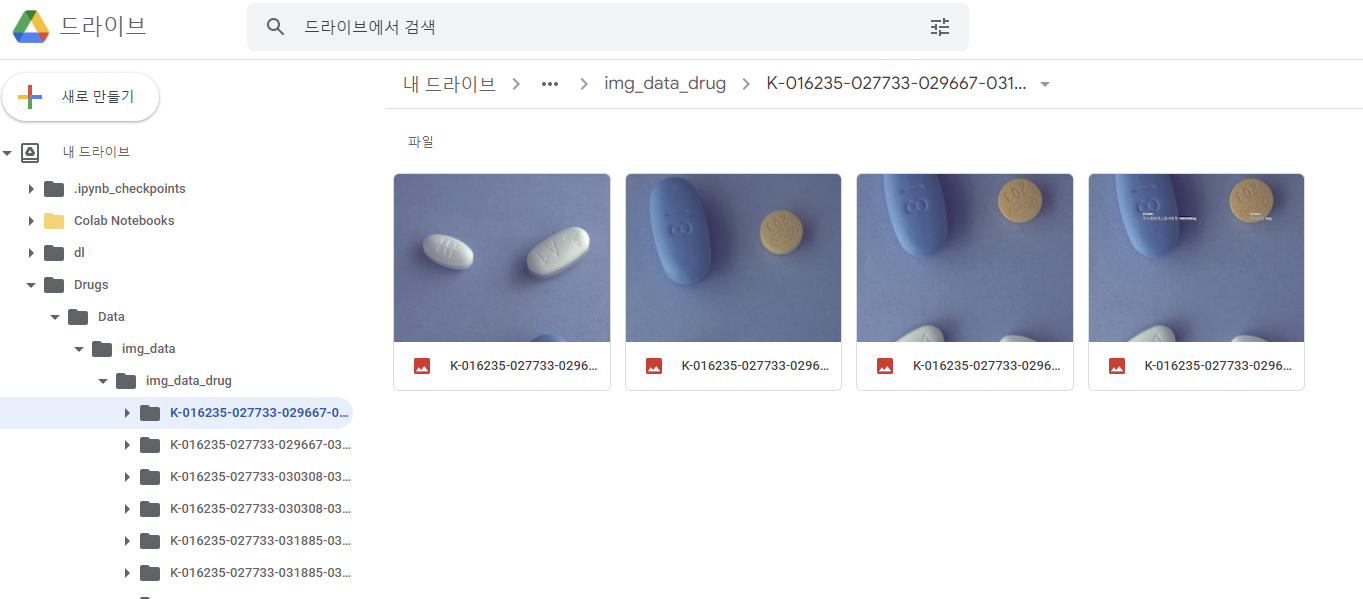

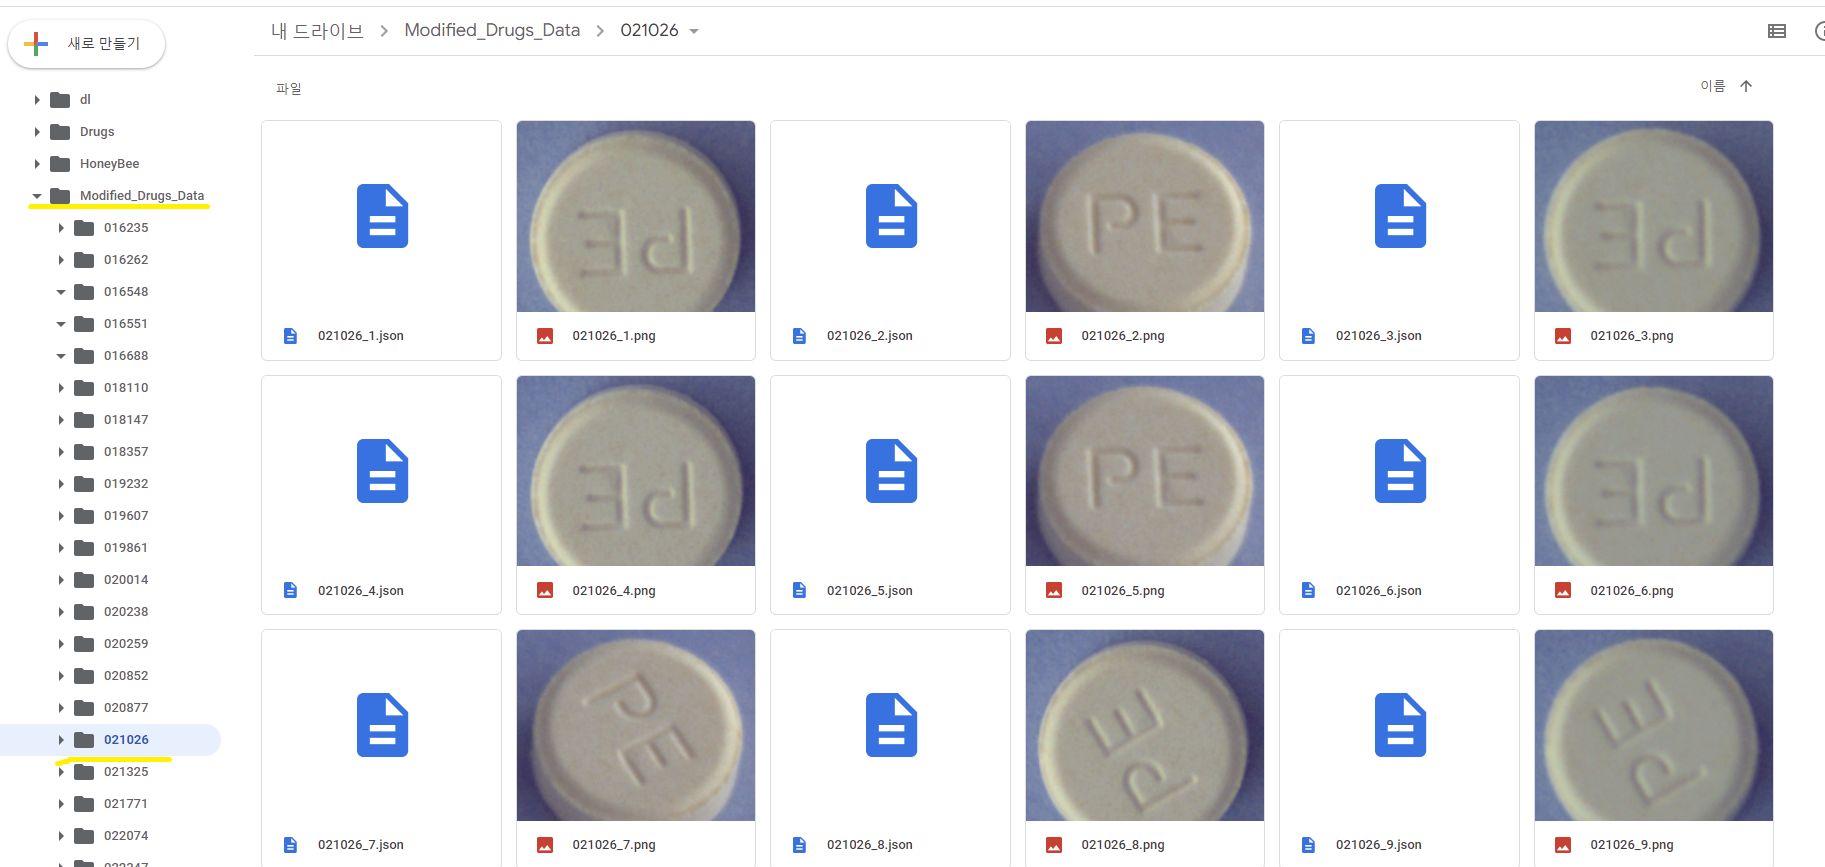

In [ ]:
# img_path = '/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-019232-020238-028424/K-019232-020238-028424_0_2_0_2_75_000_200.png'

# 이미지 경로 -> 이미지 파일 이름

def img_file_name (img_path):
  img_name = img_path.split('/')
  img_name = img_name[9]
  img_name = img_name.split('.')
  img_name = img_name[0]
  return img_name # ex) K-019232-020238-028424_0_2_0_2_75_000_200

In [ ]:
path = '/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-019232-020238-028424/K-019232-020238-028424_0_2_0_2_75_000_200.png'
img = img_file_name(path)
print(img)

K-019232-020238-028424_0_2_0_2_75_000_200


In [ ]:
# 이미지 경로 -> 약제 코드 
# 약제 코드를 알아내려는 이유: 이미지 경로에서 json 파일 경로를 만들어내기 위해서 

def group_list (img_path):
  code_list = img_path.split('/')
  code_list = code_list[8]
  code_list = code_list.split('-')
  code_list = code_list[1:]
  return code_list # ex) ['019232', '020238', '028424']

In [ ]:
path = '/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-019232-020238-028424/K-019232-020238-028424_0_2_0_2_75_000_200.png'
img_code_list = group_list(path)
print(img_code_list)

['019232', '020238', '028424']


In [ ]:
# 이미지 경로 -> 조합된 코드

def drug_group (img_path):
  path_split = img_path.split('/')
  group = path_split[8]
  return group # ex) K-019232-020238-028424

In [ ]:
path = '/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-019232-020238-028424/K-019232-020238-028424_0_2_0_2_75_000_200.png'
img_group_code = drug_group(path)
print(img_group_code)

K-019232-020238-028424


In [ ]:
# 이미지 경로 -> 해당 json 파일 경로 리스트 
# 이미지 1개 : json 파일 3/4개 

base_json_path = '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug'
def build_json_path(img_path):
  json_path_list = []
  code_list = group_list(img_path)
  for code in code_list:
    json_path = base_json_path + '/'+ drug_group(img_path)+'_json/'+'K-'+code+'/'+ img_file_name(img_path)+'.json'
    json_path_list.append(json_path)
  return json_path_list

In [ ]:
json_path_list = build_json_path(path)
print(json_path_list)

['/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-019232-020238-028424_json/K-019232/K-019232-020238-028424_0_2_0_2_75_000_200.json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-019232-020238-028424_json/K-020238/K-019232-020238-028424_0_2_0_2_75_000_200.json', '/content/drive/MyDrive/Drugs/Data/label_data/label_data_drug/K-019232-020238-028424_json/K-028424/K-019232-020238-028424_0_2_0_2_75_000_200.json']


In [ ]:
# 이미지 경로를 이용해 json 파일에서 bbox 좌표 읽어오는 함수

def bbox_coordinate (img_path):
  coordinate_list = []
  json_path_list = build_json_path(img_path)
  for json_path in json_path_list:
    with open(json_path, 'r') as file:
      data = json.load(file)
      coordinate = data['annotations'][0]['bbox']
      coordinate_list.append(coordinate)
  return coordinate_list 

In [ ]:
path2 ='/content/drive/MyDrive/Drugs/Data/img_data/img_data_drug/K-019232-020238-028424/K-019232-020238-028424_0_2_0_2_90_000_200.png'
code_list =  group_list(path2)
coordinate_list = bbox_coordinate(path2)
print(code_list)
print(coordinate_list)

['019232', '020238', '028424']
[[142, 802, 330, 263], [633, 803, 226, 223], [378, 218, 241, 243]]


In [ ]:
#이미지 crop 하고 새로운 디렉토리에 정리하기

base_path = '/content/drive/MyDrive/Modified_Drugs_Data'

def modify_img(img_path):
  code_list =  group_list(img_path)
  json_path_list = build_json_path(img_path)
  coordinate_list = bbox_coordinate(img_path)
  img = Image.open(img_path)
  #plt.imshow(img)
  #plt.show()
  i = 0
  for code in code_list:
    json_path = json_path_list[i]
    coordinate = coordinate_list[i]
    if len(coordinate) != 4: # 실행하다보니 누락된 데이터로 인해 에러 발생 -> 조건문 삽입
      i += 1
      continue
    x, y, w, h = coordinate
    cropped_img = img.crop((x, y, x+w, y+h))
    #plt.imshow(cropped_img)
    #plt.show() 

    code_path = base_path +'/'+ code
    if os.path.isdir(code_path):
      file_list = os.listdir(code_path)
      num = int(len(file_list)/2)
      if num >= 10:
        pass
      else:
        num += 1
        img_file_path = code_path + '/' + code+'_'+ str(num)+'.png'
        json_file_path = code_path + '/' + code+'_'+ str(num)+'.json'
        cropped_img.save(img_file_path)
        with open(json_path, 'r') as file:
          data = json.load(file)
        # 해당 json 파일 저장 
        with open(json_file_path, 'w') as file:
          json.dump(data, file)
    else: # code에 해당 알약의 첫번째 사진
      os.makedirs(code_path)
      # 이미지 저장
      img_file_path = code_path + '/' + code+'_1.png'
      json_file_path = code_path + '/' + code+'_1.json'
      cropped_img.save(img_file_path)
      with open(json_path, 'r') as file:
        data = json.load(file)
      # 해당 json 파일 저장 
      with open(json_file_path, 'w') as file:
        json.dump(data, file)

    i += 1


In [ ]:
for img_path in img_path_list:
  modify_img(img_path)

In [ ]:
dir_list = os.listdir('/content/drive/MyDrive/Modified_Drugs_Data')

In [ ]:
print(len(dir_list))

54


### 처리한 데이터 구성 확인

In [ ]:
print(drug_code_list[:10])

['031885', '016235', '027993', '032310', '020852', '023203', '016688', '031705', '020259', '016548']


In [ ]:
print(type(drug_code_list))

<class 'list'>


In [ ]:
drug_code_list.sort()

In [ ]:
print(drug_code_list)
print(type(drug_code_list))
print(len(drug_code_list))

['016235', '016262', '016548', '016551', '016688', '018110', '018147', '018357', '019232', '019607', '019861', '020014', '020238', '020259', '020852', '020877', '021026', '021325', '021771', '022074', '022347', '023203', '024752', '024850', '025367', '025469', '027653', '027733', '027777', '027926', '027993', '028424', '028763', '029345', '029451', '029667', '029871', '030308', '031705', '031863', '031885', '032310', '033009', '033026', '033208', '033878', '033880', '034597', '035206', '036637', '038162', '038723', '041768', '044199']
<class 'list'>
54


In [ ]:
import json

new_json_path = '/content/drive/MyDrive/Modified_Drugs_Data/016235/016235_7.json'

with open(new_json_path, 'r') as file:
    data = json.load(file)

In [ ]:
print(data['images'][0]['file_name'])

K-016235-027733-030308-035206_0_2_0_2_90_000_200.png


In [ ]:
print(data['annotations'][0]['bbox'])

[629, 865, 266, 177]


In [ ]:
print(data['images'][0]['dl_name'])

카듀엣정 5mg/20mg


In [ ]:
print(data['images'][0]['di_class_no'])

[02190]기타의 순환계용약


In [ ]:
# col: drug_code
# 약 이름
# 약 기능
# mapping code
# 원래 이미지 파일 이름
# bbox 좌표

In [ ]:
import os
import json 

dir_path = '/content/drive/MyDrive/Modified_Drugs_Data'

json_data = {}

for code in drug_code_list:
  new_json_path = dir_path + '/'+ code +'/'+code+'_7.json' #7번 파일 이용
  with open(new_json_path, 'r') as file:
    data = json.load(file)
  value_list = []
  value_list.append(data['images'][0]['dl_name'])
  value_list.append(data['images'][0]['di_class_no'])
  value_list.append(data['images'][0]['dl_mapping_code'])
  value_list.append(data['images'][0]['file_name'])
  value_list.append(data['annotations'][0]['bbox'])
  json_data[code]=value_list

In [ ]:
print(json_data)

{'016235': ['카듀엣정 5mg/20mg', '[02190]기타의 순환계용약', 'K-016235', 'K-016235-027733-030308-035206_0_2_0_2_90_000_200.png', [629, 865, 266, 177]], '016262': ['크레스토정 20mg', '[02180]동맥경화용제', 'K-016262', 'K-016262-018147-024752_0_2_0_2_75_000_200.png', [282, 125, 242, 246]], '016548': ['가바토파정 100mg', '[01130]항전간제', 'K-016548', 'K-016548-018110-021026-027993_0_2_0_2_90_000_200.png', [591, 206, 236, 226]], '016551': ['동아가바펜틴정 800mg', '[01130]항전간제', 'K-016551', 'K-016551-018110-021026-027993_0_2_0_2_90_000_200.png', [530, 48, 407, 404]], '016688': ['오마코연질캡슐(오메가-3-산에틸에스테르90)', '[02180]동맥경화용제', 'K-016688', 'K-016688-018147-024752_0_2_0_2_70_000_200.png', [479, 122, 421, 524]], '018110': ['란스톤엘에프디티정 30mg', '[02320]소화성궤양용제', 'K-018110', 'K-016548-018110-021026-029871_0_2_0_2_70_000_200.png', [611, 816, 314, 306]], '018147': ['리리카캡슐 150mg', '[01190]기타의 중추신경용약', 'K-018147', 'K-016262-018147-024752_0_2_0_2_75_000_200.png', [60, 597, 329, 401]], '018357': ['종근당글리아티린연질캡슐(콜린알포세레이트)\xa0', '[01190]기타의 중추신경용약',

In [ ]:
print(len(json_data))

54


In [ ]:
json_data = {'016235': ['카듀엣정 5mg/20mg', '[02190]기타의 순환계용약', 'K-016235', 'K-016235-027733-030308-035206_0_2_0_2_90_000_200.png', [629, 865, 266, 177]], '016262': ['크레스토정 20mg', '[02180]동맥경화용제', 'K-016262', 'K-016262-018147-024752_0_2_0_2_75_000_200.png', [282, 125, 242, 246]], '016548': ['가바토파정 100mg', '[01130]항전간제', 'K-016548', 'K-016548-018110-021026-027993_0_2_0_2_90_000_200.png', [591, 206, 236, 226]], '016551': ['동아가바펜틴정 800mg', '[01130]항전간제', 'K-016551', 'K-016551-018110-021026-027993_0_2_0_2_90_000_200.png', [530, 48, 407, 404]], '016688': ['오마코연질캡슐(오메가-3-산에틸에스테르90)', '[02180]동맥경화용제', 'K-016688', 'K-016688-018147-024752_0_2_0_2_70_000_200.png', [479, 122, 421, 524]], '018110': ['란스톤엘에프디티정 30mg', '[02320]소화성궤양용제', 'K-018110', 'K-016548-018110-021026-029871_0_2_0_2_70_000_200.png', [611, 816, 314, 306]], '018147': ['리리카캡슐 150mg', '[01190]기타의 중추신경용약', 'K-018147', 'K-016262-018147-024752_0_2_0_2_75_000_200.png', [60, 597, 329, 401]], '018357': ['종근당글리아티린연질캡슐(콜린알포세레이트)\xa0', '[01190]기타의 중추신경용약', 'K-018357', 'K-018357-028424-038162_0_2_0_2_75_000_200.png', [324, 90, 317, 284]], '019232': ['콜리네이트연질캡슐 400mg', '[01190]기타의 중추신경용약', 'K-019232', 'K-019232-020238-033026_0_2_0_2_90_000_200.png', [141, 802, 330, 263]], '019607': ['스토가정 10mg', '[02320]소화성궤양용제', 'K-019607', 'K-016548-019607-021026-029871_0_2_0_2_75_000_200.png', [167, 214, 153, 150]], '019861': ['노바스크정 5mg', '[02140]혈압강하제', 'K-019861', 'K-016262-019861-028763-038723_0_2_0_2_90_000_200.png', [120, 866, 225, 169]], '020014': ['마도파정', '[01190]기타의 중추신경용약', 'K-020014', 'K-016262-020014-024752_0_2_0_2_70_000_200.png', [558, 311, 335, 317]], '020238': ['플라빅스정 75mg', '[02180]동맥경화용제', 'K-020238', 'K-019232-020238-033026_0_2_0_2_90_000_200.png', [634, 803, 225, 222]], '020259': ['자트랄엑스엘정 10mg', '[02590]기타의 비뇨생식기관 및 항문용약', 'K-020259', 'K-019232-020259-036637_0_2_0_2_70_000_200.png', [396, 859, 220, 241]], '020852': ['베시케어정 10mg', '[02590]기타의 비뇨생식기관 및 항문용약', 'K-020852', 'K-016262-018357-020852_0_2_0_2_70_000_200.png', [123, 299, 201, 193]], '020877': ['엑스포지정 5/160mg', '[02140]혈압강하제', 'K-020877', 'K-016262-020877-028763-038723_0_2_0_2_90_000_200.png', [133, 824, 285, 313]], '021026': ['펠루비정(펠루비프로펜)', '[01140]해열.진통.소염제', 'K-021026', 'K-016548-018110-021026-029871_0_2_0_2_70_000_200.png', [676, 274, 177, 172]], '021325': ['아토르바정 10mg', '[02180]동맥경화용제', 'K-021325', 'K-018147-020852-021325_0_2_0_2_75_000_200.png', [609, 683, 151, 243]], '021771': ['라비에트정 20mg', '[02320]소화성궤양용제', 'K-021771', 'K-016548-021026-021771-029871_0_2_0_2_90_000_200.png', [123, 243, 190, 186]], '022074': ['리피로우정 20mg', '[02180]동맥경화용제', 'K-022074', 'K-018147-020852-022074_0_2_0_2_90_000_200.png', [587, 832, 185, 185]], '022347': ['자누비아정 50mg', '[03960]당뇨병용제', 'K-022347', 'K-016262-022347-025469-038723_0_2_0_2_90_000_200.png', [134, 174, 210, 196]], '023203': ['쿠에타핀정 25mg', '[01170]정신신경용제', 'K-023203', 'K-016548-018110-023203-027926_0_2_0_2_70_000_200.png', [683, 306, 139, 136]], '024752': ['토비애즈서방정 4mg', '[02590]기타의 비뇨생식기관 및 항문용약', 'K-024752', 'K-016262-018357-024752_0_2_0_2_75_000_200.png', [527, 705, 325, 214]], '024850': ['놀텍정 10mg', '[02320]소화성궤양용제', 'K-024850', 'K-016548-021026-024850-027993_0_2_0_2_90_000_200.png', [139, 177, 186, 286]], '025367': ['자누메트정 50/850mg', '[03960]당뇨병용제', 'K-025367', 'K-016262-025367-025469-038723_0_2_0_2_90_000_200.png', [63, 160, 418, 443]], '025469': ['아모잘탄정 5/100mg', '[02140]혈압강하제', 'K-025469', 'K-016262-025469-028763-038723_0_2_0_2_90_000_200.png', [16, 854, 382, 205]], '027653': ['세비카정 10/40mg', '[02140]혈압강하제', 'K-027653', 'K-016262-027653-028763-038723_0_2_0_2_90_000_200.png', [100, 854, 225, 208]], '027733': ['트윈스타정 40/5mg', '[02140]혈압강하제', 'K-027733', 'K-016235-027733-030308-035206_0_2_0_2_90_000_200.png', [92, 817, 326, 261]], '027777': ['카나브정 60mg', '[02140]혈압강하제', 'K-027777', 'K-016235-027777-028763-036637_0_2_0_2_75_000_200.png', [114, 780, 175, 206]], '027926': ['울트라셋이알서방정', '[01140]해열.진통.소염제', 'K-027926', 'K-016548-018110-027926-029871_0_2_0_2_90_000_200.png', [186, 606, 256, 475]], '027993': ['졸로푸트정 100mg', '[01170]정신신경용제', 'K-027993', 'K-016548-018110-027993-029345_0_2_0_2_75_000_200.png', [139, 773, 165, 342]], '028424': ['플리바스정 50mg', '[02590]기타의 비뇨생식기관 및 항문용약', 'K-028424', 'K-018357-028424-036637_0_2_0_2_75_000_200.png', [57, 729, 247, 253]], '028763': ['트라젠타정(리나글립틴)', '[03960]당뇨병용제', 'K-028763', 'K-016235-027777-028763-036637_0_2_0_2_75_000_200.png', [134, 214, 209, 201]], '029345': ['비모보정 500/20mg', '[01140]해열.진통.소염제', 'K-029345', 'K-016548-018110-029345-029871_0_2_0_2_75_000_200.png', [63, 714, 271, 460]], '029451': ['레일라정', '[01140]해열.진통.소염제', 'K-029451', 'K-016548-018110-029451-029871_0_2_0_2_70_000_200.png', [503, 239, 402, 239]], '029667': ['리바로정 4mg', '[02180]동맥경화용제', 'K-029667', 'K-016235-027733-029667-031885_0_2_0_2_90_000_200.png', [627, 158, 223, 214]], '029871': ['렉사프로정 15mg', '[01170]정신신경용제', 'K-029871', 'K-016548-018110-029345-029871_0_2_0_2_75_000_200.png', [620, 804, 250, 175]], '030308': ['트라젠타듀오정 2.5/850mg', '[03960]당뇨병용제', 'K-030308', 'K-016235-027777-029667-030308_0_2_0_2_90_000_200.png', [102, 159, 416, 385]], '031705': ['낙소졸정 500/20mg', '[01140]해열.진통.소염제', 'K-031705', 'K-016548-018110-029871-031705_0_2_0_2_75_000_200.png', [550, 695, 251, 455]], '031863': ['아질렉트정(라사길린메실산염)', '[01190]기타의 중추신경용약', 'K-031863', 'K-016262-024752-031863_0_2_0_2_70_000_200.png', [160, 285, 207, 207]], '031885': ['자누메트엑스알서방정 100/1000mg', '[03960]당뇨병용제', 'K-031885', 'K-016235-027733-031885-036637_0_2_0_2_70_000_200.png', [534, 634, 409, 518]], '032310': ['글리아타민연질캡슐', '[01190]기타의 중추신경용약', 'K-032310', 'K-016262-024752-032310_0_2_0_2_70_000_200.png', [128, 165, 223, 366]], '033009': ['신바로정', '[01140]해열.진통.소염제', 'K-033009', 'K-016548-018110-029871-033009_0_2_0_2_70_000_200.png', [119, 216, 248, 359]], '033026': ['트루패스정 4mg', '[02590]기타의 비뇨생식기관 및 항문용약', 'K-033026', 'K-018357-033026-035206_0_2_0_2_75_000_200.png', [114, 689, 189, 280]], '033208': ['에스원엠프정 20mg', '[02320]소화성궤양용제', 'K-033208', 'K-016548-021026-029871-033208_0_2_0_2_75_000_200.png', [112, 183, 205, 197]], '033878': ['브린텔릭스정 20mg', '[01170]정신신경용제', 'K-033878', 'K-016548-018110-029345-033878_0_2_0_2_75_000_200.png', [650, 848, 235, 154]], '033880': ['글리틴정(콜린알포세레이트)', '[01190]기타의 중추신경용약', 'K-033880', 'K-016262-024752-033880_0_2_0_2_70_000_200.png', [458, 246, 430, 287]], '034597': ['제미메트서방정 50/1000mg', '[03960]당뇨병용제', 'K-034597', 'K-016235-027733-034597-036637_0_2_0_2_90_000_200.png', [72, 102, 409, 455]], '035206': ['아토젯정 10/40mg', '[02180]동맥경화용제', 'K-035206', 'K-019232-020259-035206_0_2_0_2_75_000_200.png', [524, 537, 268, 403]], '036637': ['로수젯정10/5밀리그램', '[02180]동맥경화용제', 'K-036637', 'K-019232-020259-036637_0_2_0_2_70_000_200.png', [165, 276, 213, 239]], '038162': ['로수바미브정 10/20mg', '[02180]동맥경화용제', 'K-038162', 'K-019232-020259-038162_0_2_0_2_90_000_200.png', [612, 796, 223, 277]], '038723': ['엔트레스토필름코팅정 200mg', '[02190]기타의 순환계용약', 'K-038723', 'K-016262-019861-028763-038723_0_2_0_2_90_000_200.png', [572, 827, 377, 197]], '041768': ['카발린캡슐 25mg', '[01190]기타의 중추신경용약', 'K-041768', 'K-016262-024752-041768_0_2_0_2_70_000_200.png', [108, 283, 273, 287]], '044199': ['케이캡정 50mg', '[02320]소화성궤양용제', 'K-044199', 'K-016548-021026-029871-044199_0_2_0_2_70_000_200.png', [641, 857, 274, 221]]}

In [ ]:
print(len(json_data))

54


In [ ]:
for key, value in json_data.items():
  print(key)
  print(value)
  break

016235
['카듀엣정 5mg/20mg', '[02190]기타의 순환계용약', 'K-016235', 'K-016235-027733-030308-035206_0_2_0_2_90_000_200.png', [629, 865, 266, 177]]


In [ ]:
# /content/drive/MyDrive/Modified_Drugs_Data/016235/016235_7.json

In [ ]:
import pandas as pd

data_table = pd.DataFrame(json_data)
data_table

,016235,016262,016548,016551,016688,018110,018147,018357,019232,019607,...,033208,033878,033880,034597,035206,036637,038162,038723,041768,044199
0,카듀엣정 5mg/20mg,크레스토정 20mg,가바토파정 100mg,동아가바펜틴정 800mg,오마코연질캡슐(오메가-3-산에틸에스테르90),란스톤엘에프디티정 30mg,리리카캡슐 150mg,종근당글리아티린연질캡슐(콜린알포세레이트),콜리네이트연질캡슐 400mg,스토가정 10mg,...,에스원엠프정 20mg,브린텔릭스정 20mg,글리틴정(콜린알포세레이트),제미메트서방정 50/1000mg,아토젯정 10/40mg,로수젯정10/5밀리그램,로수바미브정 10/20mg,엔트레스토필름코팅정 200mg,카발린캡슐 25mg,케이캡정 50mg
1,[02190]기타의 순환계용약,[02180]동맥경화용제,[01130]항전간제,[01130]항전간제,[02180]동맥경화용제,[02320]소화성궤양용제,[01190]기타의 중추신경용약,[01190]기타의 중추신경용약,[01190]기타의 중추신경용약,[02320]소화성궤양용제,...,[02320]소화성궤양용제,[01170]정신신경용제,[01190]기타의 중추신경용약,[03960]당뇨병용제,[02180]동맥경화용제,[02180]동맥경화용제,[02180]동맥경화용제,[02190]기타의 순환계용약,[01190]기타의 중추신경용약,[02320]소화성궤양용제
2,K-016235,K-016262,K-016548,K-016551,K-016688,K-018110,K-018147,K-018357,K-019232,K-019607,...,K-033208,K-033878,K-033880,K-034597,K-035206,K-036637,K-038162,K-038723,K-041768,K-044199
3,K-016235-027733-030308-035206_0_2_0_2_90_000_2...,K-016262-018147-024752_0_2_0_2_75_000_200.png,K-016548-018110-021026-027993_0_2_0_2_90_000_2...,K-016551-018110-021026-027993_0_2_0_2_90_000_2...,K-016688-018147-024752_0_2_0_2_70_000_200.png,K-016548-018110-021026-029871_0_2_0_2_70_000_2...,K-016262-018147-024752_0_2_0_2_75_000_200.png,K-018357-028424-038162_0_2_0_2_75_000_200.png,K-019232-020238-033026_0_2_0_2_90_000_200.png,K-016548-019607-021026-029871_0_2_0_2_75_000_2...,...,K-016548-021026-029871-033208_0_2_0_2_75_000_2...,K-016548-018110-029345-033878_0_2_0_2_75_000_2...,K-016262-024752-033880_0_2_0_2_70_000_200.png,K-016235-027733-034597-036637_0_2_0_2_90_000_2...,K-019232-020259-035206_0_2_0_2_75_000_200.png,K-019232-020259-036637_0_2_0_2_70_000_200.png,K-019232-020259-038162_0_2_0_2_90_000_200.png,K-016262-019861-028763-038723_0_2_0_2_90_000_2...,K-016262-024752-041768_0_2_0_2_70_000_200.png,K-016548-021026-029871-044199_0_2_0_2_70_000_2...
4,"[629, 865, 266, 177]","[282, 125, 242, 246]","[591, 206, 236, 226]","[530, 48, 407, 404]","[479, 122, 421, 524]","[611, 816, 314, 306]","[60, 597, 329, 401]","[324, 90, 317, 284]","[141, 802, 330, 263]","[167, 214, 153, 150]",...,"[112, 183, 205, 197]","[650, 848, 235, 154]","[458, 246, 430, 287]","[72, 102, 409, 455]","[524, 537, 268, 403]","[165, 276, 213, 239]","[612, 796, 223, 277]","[572, 827, 377, 197]","[108, 283, 273, 287]","[641, 857, 274, 221]"


In [ ]:
data_table.loc[1]

016235            [02190]기타의 순환계용약
016262               [02180]동맥경화용제
016548                 [01130]항전간제
016551                 [01130]항전간제
016688               [02180]동맥경화용제
018110              [02320]소화성궤양용제
018147           [01190]기타의 중추신경용약
018357           [01190]기타의 중추신경용약
019232           [01190]기타의 중추신경용약
019607              [02320]소화성궤양용제
019861                [02140]혈압강하제
020014           [01190]기타의 중추신경용약
020238               [02180]동맥경화용제
020259    [02590]기타의 비뇨생식기관 및 항문용약
020852    [02590]기타의 비뇨생식기관 및 항문용약
020877                [02140]혈압강하제
021026            [01140]해열.진통.소염제
021325               [02180]동맥경화용제
021771              [02320]소화성궤양용제
022074               [02180]동맥경화용제
022347                [03960]당뇨병용제
023203               [01170]정신신경용제
024752    [02590]기타의 비뇨생식기관 및 항문용약
024850              [02320]소화성궤양용제
025367                [03960]당뇨병용제
025469                [02140]혈압강하제
027653                [02140]혈압강하제
027733                [02140]혈압강하제
027777              

## 3. 모델 형성하기

목표: 혈압약 인지 아닌지 구분하는 모델을 만들어보자


#### Fine Tunning